# [TM&NLP] Project: Tweets Tone detector
### Project by  Brusamarello Michelangelo and Meloni Diego
The main objective of our project is to make a classifier that detects whether tweets are:
- Regular
- Sarcastic
- Ironic
- Figurative (both sarcastic and ironic)

## Project setup
We load the dataset from a GitHub repository, in this way the implementation works consistently without the need of downloading dataset or making harder setups with google drive.

Note: Google Colab comes with some libraries preinstalled (like tensorflow), however during the project we will occasionally install some others to make it run properly.

In [ ]:
import pandas as pd

# Define the GitHub raw file URLs
train_file = "https://github.com/Diego-Meloni/AI-Projects/raw/refs/heads/main/Tweet%20Tone%20Classifier/train.csv"
test_file = "https://github.com/Diego-Meloni/AI-Projects/raw/refs/heads/main/Tweet%20Tone%20Classifier/test.csv"

# Load the dataset directly from GitHub
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

print("Dataset loaded")
print("Training set shape:", train.shape)
print("Test set shape:", test.shape)

Dataset loaded
Training set shape: (81408, 2)
Test set shape: (8128, 2)


## Data preprocessing
We gather some information about the data in our dataset and we apply some preprocessing steps

In [ ]:
# Check for nan values in the train dataset
print(f"Nan values in train dataset: \n{train.isnull().sum()}\n")
print(f"Nan values in test dataset: \n{test.isnull().sum()}")

Nan values in train dataset: 
tweets    0
class     0
dtype: int64

Nan values in test dataset: 
tweets    2
class     9
dtype: int64


In [ ]:
# Remove nan values from the test dataframe
test.dropna(subset=['class', 'tweets'], inplace=True)
print(f"Nan values in test dataset: \n{test.isnull().sum()}")

Nan values in test dataset: 
tweets    0
class     0
dtype: int64


In [ ]:
# Small sample of the dataset
train.head(3)

,tweets,class
0,Be aware dirty step to get money #staylight ...,figurative
1,#sarcasm for #people who don't understand #diy...,figurative
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative


Here we define some functions which are useful for preprocessing and testing and we will later use them in the project.

In [ ]:
# We define some useful functions we will use in the project
import nltk
import re
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


# List of stopwords
stop_words = list(stopwords.words('english'))

# Function to remove mentions
def remove_at(text):
  return re.sub(r'@\S+', '', text)

# Function to remove urls
def remove_urls(text):
  return re.sub(r'https?://\S+|www\.\S+', '', text)

# Function to remove hashtags
def remove_hashtags(text):
  return re.sub(r'#', '', text)

# Function to remove non english characters
def remove_nonenglish_characters(text):
  return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Function that removes words "irony" and "sarcasm"
def remove_sarcasm_irony(text):
  text = re.sub(r'irony', '', text)
  text = re.sub(r'sarcasm', '', text)
  return text


def tokenizer_function(sentence):
    # Lowercase all sentences
    sentence = sentence.lower()

    # Remove all mentions of other profiles starting with '@', not informative for our task
    sentence = remove_at(sentence)
    # Remove all urls which only act as noise
    sentence = remove_urls(sentence)
    # Remove the hashtag '#' character to be able to perform subword tokenization
    sentence = remove_hashtags(sentence)
    # Remove non english characters
    sentence = remove_nonenglish_characters(sentence)

    # Tokenize it using nltk
    my_tokenized_tokens = word_tokenize(sentence)

    # Removing stop words and punctuations
    mytokens = [word for word in my_tokenized_tokens if word not in stop_words]

    # return preprocessed list of tokens
    return mytokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Preprocessing considerations

To build our vocabulary, we first consider the nature of our dataset: a collection of tweets. This type of data frequently includes internet slang, URLs, mentions, emojis, and hashtags — all of which introduce irregularities and challenges for traditional word-level tokenization.

We opted to **remove links, mentions and non english characters**, since they usually add noise and complexity without providing useful information for the classification.

Tweets often contain
- out-of-vocabulary (OOV) words
- creative spellings
- hashtags that combine multiple words without spaces.

These elements can still carry meaningful signals for our labels, and we want to preserve that information where possible.

To handle this, we opted to use **subword tokenization with Byte Pair Encoding (BPE)**. BPE breaks words into smaller, more frequent units, which helps the model deal with rare or unseen tokens while retaining useful subword information, moreover we have more flexibility because we can choose the vocabulary size.

This approach reduces the OOV problem, enables better generalization on unseen data, and effectively handles the noisy, informal language often found on Twitter.

As a result, our vocabulary is composed of **subword units** rather than whole words, making the model more robust and better suited for social media text classification.

In [ ]:
# Apply preprocessing
train['tweets'] = train['tweets'].apply(tokenizer_function)
test['tweets'] = test['tweets'].apply(tokenizer_function)
train['tweets'] = train['tweets'].apply(lambda x: ' '.join(x))
test['tweets'] = test['tweets'].apply(lambda x: ' '.join(x))

# The test dataset without the sarcasm and irony words
test['no_irony_sarcasm'] = test['tweets'].apply(remove_sarcasm_irony)

Note: We created a version of our dataset from which we have removed "sarcasm" and "irony", which we will later use for many confrontations

### Training the Subword Vocabulary

The `tokenizer.train_from_iterator()` function uses our list of tweets  (the dataset) to create a subword vocabulary based on the most frequent token merges.
We specify a vocabulary size (e.g., 5000) to limit memory usage and generalize well.

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers import decoders

In [ ]:
vocab_size = 5000

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

tokenizer.pre_tokenizer = Whitespace()


train_files = train['tweets'].to_list()

trainer = BpeTrainer(vocab_size=vocab_size,
                     special_tokens=['[UNK]'])

#use train_from_iterator since we already have the training set as a list in python
tokenizer.train_from_iterator(train_files, trainer)

saved_tokenizer = './tokenizer-irony-sarcasm-tweets.json'

tokenizer.save(saved_tokenizer)

In [ ]:
# We can now visualize the vocabulary
vocab = tokenizer.get_vocab()
vocab

### Converting Class Labels to Integers

Machine learning models work with numerical labels, not strings, so we map each class as follows:
- regular → 0
- irony → 1
- sarcasm → 2
- figurative → 3

In [ ]:
import numpy as np

# encode different classes as integers to be able to use deep neural netwrok with sparse categorical crossentropy loss
train.loc[train['class']=='regular', 'class'] = 0
train.loc[train['class']=='irony', 'class'] = 1
train.loc[train['class']=='sarcasm', 'class'] = 2
train.loc[train['class']=='figurative', 'class'] =3

test.loc[test['class']=='regular', 'class'] = 0
test.loc[test['class']=='irony', 'class'] = 1
test.loc[test['class']=='sarcasm', 'class'] = 2
test.loc[test['class']=='figurative', 'class'] =3

y_train = np.array(train['class'])
y_test = np.array(test['class'])
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')


## Tweets representation - Count based embeddings

### Creating TF-IDF Vectors Using Subwords

TF-IDF stands for Term Frequency-Inverse Document Frequency. It gives higher weights to subwords that are:

- Frequent in a single tweet (TF) (Tweets are our documents)
- Rare across all tweets (IDF)

This helps highlight words that are more informative and reduce the weight of common stopwords like "the" or "is".

By combining TF-IDF with subword tokenization, we ensure that even rare parts of compound or invented words contribute meaningfully.


In [ ]:
"""
Custom tokenizer to be able to use CountVectorizer to obtain our co-occurence
matrix using our sub-word vocabulary because we need it to be callable.
"""
def custom_tokenizer(text):
  return tokenizer.encode(text).tokens

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

docs_train = list(train['tweets'])
docs_test = list(test['tweets'])
docs_test_no_irony_sarcasm = list(test['no_irony_sarcasm'])

vectorizer = CountVectorizer(tokenizer=custom_tokenizer, preprocessor=None)
tfidf_transformer = TfidfTransformer()
X_train_count = vectorizer.fit_transform(docs_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)

#we reuse the tokenizer and the tf-idf transformer already trained on the train dataset for consistency and to avoid different dimensionalities
X_test_count = vectorizer.transform(docs_test)
X_test_tfidf = tfidf_transformer.transform(X_test_count)

X_test_no_irony_sarcasm_count = vectorizer.transform(docs_test_no_irony_sarcasm)
X_test_no_irony_sarcasm_tfidf = tfidf_transformer.transform(X_test_no_irony_sarcasm_count)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Tweet representation using Truncated SVD
TF-IDF matrices are very high-dimensional and sparse which can slow down training and cause overfitting.

We apply **Truncated Singular Value Decomposition (SVD)** to reduce the number of features:
- It captures the most important "topics" or patterns in the data.
- It makes the features more manageable for classification.

We test 3 configurations:
- 50 dimensions
- 100 dimensions
- 200 dimensions

This allows us to compare how the number of features affects model performance later.

In [ ]:
from sklearn.decomposition import TruncatedSVD

n_components = 200

svd200 = TruncatedSVD(n_components=n_components)

X_train_svd200 = svd200.fit_transform(X_train_tfidf)
X_test_svd200 = svd200.transform(X_test_tfidf)
X_test_no_svd200 = svd200.transform(X_test_no_irony_sarcasm_tfidf)

n_components = 100

svd100 = TruncatedSVD(n_components=n_components)
X_train_svd100 = svd100.fit_transform(X_train_tfidf)
X_test_svd100 = svd100.transform(X_test_tfidf)
X_test_no_svd100 = svd100.transform(X_test_no_irony_sarcasm_tfidf)

n_components = 50

svd50 = TruncatedSVD(n_components=n_components)
X_train_svd50 = svd50.fit_transform(X_train_tfidf)
X_test_svd50 = svd50.transform(X_test_tfidf)
X_test_no_svd50 = svd50.transform(X_test_no_irony_sarcasm_tfidf)

## Classification

We're using Keras (via TensorFlow) to build a simple classifier which will take our text representation embeddings (TF-IDF, or SVD-reduced) as input and output one of the 4 classes:  
- **Regular**
- **Irony**
- **Sarcasm**
- **Figurative**

We define a function `create_model()` to make it easy to instantiate multiple models with different configurations.

- **Input layer**: matches the size of the input vector (TF-IDF or SVD-reduced).
- **Hidden layers**: 64 and 32 neurons with ReLU activation.
- **Regularization**: uses both L1 and L2 penalties to prevent overfitting.
- **Dropout**: randomly drops 20% of neurons during training for further regularization.
- **Output layer**: uses softmax to output probabilities for the 4 classes.

We create two versions for each model:
- One with regularization
- One without regularization

In [ ]:
import tensorflow as tf
import keras
import tensorflow.keras as K
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1_l2, l1, l2


def create_model(input_shape, n_classes=4, hid_act='relu', regularization=True):
  if regularization:
    model = K.Sequential()
    model.add(layers.Input(input_shape))
    model.add(layers.Dense(64, activation=hid_act, kernel_regularizer=l1_l2(l1=0.001, l2=0.01)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation=hid_act, kernel_regularizer=l1_l2(l1=0.001, l2=0.01)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(n_classes, activation='softmax'))

  else:
    model = K.Sequential()
    model.add(layers.Input(input_shape))
    model.add(layers.Dense(64, activation=hid_act))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation=hid_act))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(n_classes, activation='softmax'))

  return model


We create the classificator model for tf-idf embeddings.

In [ ]:
INPUT_SHAPE = X_train_tfidf.shape[1:]

lr = 4*10**-3

model_count_reg = create_model(INPUT_SHAPE)
model_tfidf_reg = create_model(INPUT_SHAPE)

model_count = create_model(INPUT_SHAPE, regularization=False)
model_tfidf = create_model(INPUT_SHAPE, regularization=False)

model_count_reg.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

model_tfidf_reg.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

model_count.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

model_tfidf.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])


model_count.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │       319,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,572 (1.23 MB)

 Trainable params: 321,572 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Similarly to previouos step we create a classificator model for SVD embeddings, in particular we create a different model for each SVD embedding size we used.

In [ ]:
INPUT_SHAPE = X_train_svd200.shape[1:]
lr = 4*10**-3

model_svd200_reg = create_model(INPUT_SHAPE)
model_svd200 = create_model(INPUT_SHAPE, regularization=False)

model_svd200_reg.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

model_svd200.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

model_svd200.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,076 (58.89 KB)

 Trainable params: 15,076 (58.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
INPUT_SHAPE = X_train_svd100.shape[1:]
lr = 4*10**-3

model_svd100_reg = create_model(INPUT_SHAPE)
model_svd100 = create_model(INPUT_SHAPE, regularization=False)

model_svd100_reg.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

model_svd100.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

model_svd100.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,676 (33.89 KB)

 Trainable params: 8,676 (33.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
INPUT_SHAPE = X_train_svd50.shape[1:]
lr = 4*10**-3

model_svd50_reg = create_model(INPUT_SHAPE)
model_svd50 = create_model(INPUT_SHAPE, regularization=False)

model_svd50_reg.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

model_svd50.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

model_svd50.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,476 (21.39 KB)

 Trainable params: 5,476 (21.39 KB)

 Non-trainable params: 0 (0.00 B)

### Training Strategy

- **Epochs**: 4 for TF-IDF since it is very resourse expensive and we saw it converges rapidly, 30 for SVD (lower-dimensional inputs might require more epochs).
- **Batch size**: 500 (large enough to stabilize training without memory overflow).
- **Shuffle**: ensures that the model sees a different order of samples each epoch, improving generalization.

Each model is trained independently to later compare performance across:
- Vectorization methods: Count, TF-IDF, SVD
- Regularization: With vs. Without
- Dimensionality: 50, 100, 200

In [ ]:
epochs = 4
batch_size = 500

model_tfidf_reg.fit(X_train_tfidf, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True)

Epoch 1/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.3106 - loss: 2.6214
Epoch 2/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 175s 913ms/step - accuracy: 0.5681 - loss: 1.3507
Epoch 3/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 164s 682ms/step - accuracy: 0.6845 - loss: 1.2005
Epoch 4/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 663ms/step - accuracy: 0.6957 - loss: 1.1367


In [ ]:
epochs = 4
batch_size = 500

model_tfidf.fit(X_train_tfidf, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True)

Epoch 1/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.5362 - loss: 1.0005
Epoch 2/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 874ms/step - accuracy: 0.7330 - loss: 0.5199
Epoch 3/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 174s 705ms/step - accuracy: 0.7386 - loss: 0.5016
Epoch 4/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 370ms/step - accuracy: 0.7379 - loss: 0.4975


In [ ]:
epochs = 30
batch_size = 500

model_svd200_reg.fit(X_train_svd200, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3190 - loss: 2.0815
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4904 - loss: 1.1900
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6173 - loss: 1.1121
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6889 - loss: 0.9774
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6935 - loss: 0.9256
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7007 - loss: 0.8968
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6972 - loss: 0.8830
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7027 - loss: 0.8653
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7051 - loss: 0.8510
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7041 - loss: 0.8415
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7049 - loss: 0.8348
Epoch 12/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

In [ ]:
epochs = 30
batch_size = 500

model_svd200.fit(X_train_svd200, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5229 - loss: 1.0078
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7316 - loss: 0.5181
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7338 - loss: 0.5074
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7408 - loss: 0.5003
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7374 - loss: 0.4997
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7381 - loss: 0.4983
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7393 - loss: 0.4980
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7380 - loss: 0.4980
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7391 - loss: 0.4967
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7392 - loss: 0.4943
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7403 - loss: 0.4962
Epoch 12/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

In [ ]:
epochs = 30
batch_size = 500

model_svd100_reg.fit(X_train_svd100, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3604 - loss: 1.9922
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5332 - loss: 1.1560
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6794 - loss: 1.0127
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6931 - loss: 0.9408
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7014 - loss: 0.8942
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7077 - loss: 0.8689
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7048 - loss: 0.8456
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7094 - loss: 0.8322
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7112 - loss: 0.8180
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7103 - loss: 0.8072
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7139 - loss: 0.7941
Epoch 12/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

In [ ]:
epochs = 30
batch_size = 500

model_svd100.fit(X_train_svd100, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5658 - loss: 0.9855
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7372 - loss: 0.5147
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7369 - loss: 0.5046
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7379 - loss: 0.5001
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7400 - loss: 0.4981
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7376 - loss: 0.4997
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7379 - loss: 0.4990
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7370 - loss: 0.4995
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7401 - loss: 0.4956
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7411 - loss: 0.4952
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7410 - loss: 0.4941
Epoch 12/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

In [ ]:
epochs = 30
batch_size = 500

model_svd50_reg.fit(X_train_svd50, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4239 - loss: 1.8757
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6923 - loss: 1.0425
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7098 - loss: 0.9249
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7150 - loss: 0.8783
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7226 - loss: 0.8440
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7223 - loss: 0.8212
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7248 - loss: 0.8034
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7238 - loss: 0.7901
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7288 - loss: 0.7758
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7246 - loss: 0.7665
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7285 - loss: 0.7567
Epoch 12/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

In [ ]:
epochs = 30
batch_size = 500

model_svd50.fit(X_train_svd50, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6081 - loss: 0.9728
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7324 - loss: 0.5195
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7388 - loss: 0.5047
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7374 - loss: 0.5019
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7366 - loss: 0.5009
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7393 - loss: 0.5001
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7356 - loss: 0.5004
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7361 - loss: 0.4998
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7381 - loss: 0.4979
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7354 - loss: 0.5011
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7381 - loss: 0.4969
Epoch 12/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

## Evaluation
### - For traditional models

We want to evaluate both regularized and non-regularized versions of classifiers trained on:

- **TF-IDF**
- **SVD (200D, 100D, 50D)**
- **Word2Vec** (we will do it later)

For each configuration we:

- Compute precision, recall, and F1 (macro).
- Display confusion matrices to visualize performance.

### Consideration

While developing our project we have seen by looking at the covariance matrix that the model has higher missclassification for the "figurative" tweets.

We hypothetised that the reason for this behavior could be that many tweets include hashtags like #sarcasm and #irony, so when it sees none of them it assigns the tweet to the regular class, when it sees sarcasm it says it's a sarcastic tweet, while when it sees irony it outputs the ironic classification.

To deal with this problem we have tried to run the evaluation both on the regular dataset and on a dataset from which the words sarcasm and irony have been removed. When doing so the classifications of figurative tweets usually raises a bit but the overall performance of the model drops down significantly.

This is what we would expect anyway because the line between irony, sarcasm and a combination of the two is very unclear also for humans and tweets are full of slengs and short sentences which are sometimes hard to interpret.
It also means the model gives high relevance to wether or not it can "find the answer in the question".

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

254/254 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step
COUNT BASED MODEL
Precision score with regularizer:0.20871550910993006, without regularizer:0.2847678020971606
Recall score with regularizer:0.24477055370021028, without regularizer:0.2592785364740174
F1 score with regularizer:0.1849716372613701, without regularizer:0.16126046368587763
CONFUSION MATRIX WITH REGULARIZED MODEL


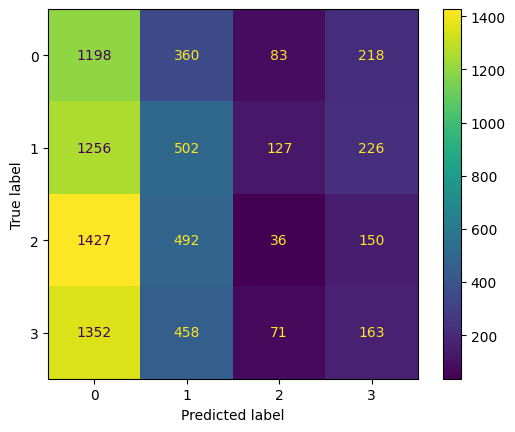

CONFUSION MATRIX WITH NON-REGULARIZED MODEL


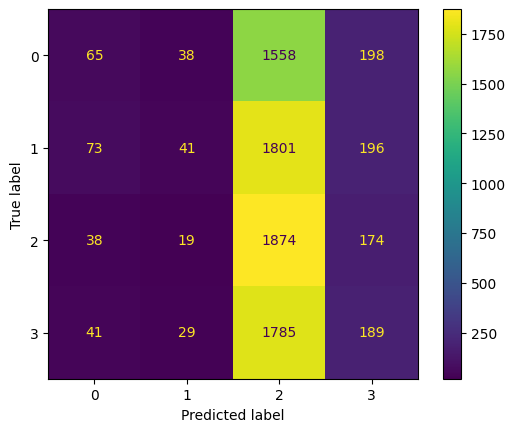

254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
COUNT BASED MODEL - NO IRONY & SARCASM
Precision score with regularizer:0.2504837438500382, without regularizer:0.2714106612142227
Recall score with regularizer:0.2545484276648384, without regularizer:0.25271817052854667
F1 score with regularizer:0.2008814765071403, without regularizer:0.1581214669672829
CONFUSION MATRIX WITH REGULARIZED MODEL - NO IRONY & SARCASM


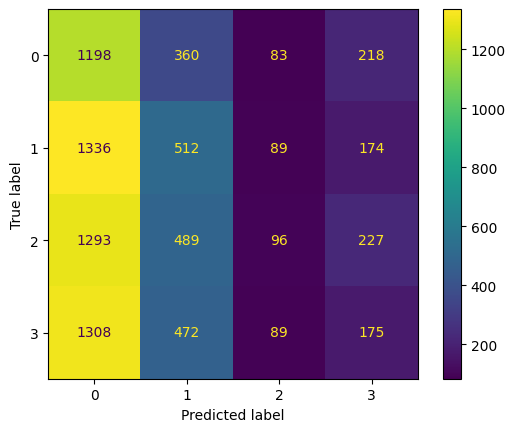

CONFUSION MATRIX WITH NON-REGULARIZED MODEL - NO IRONY & SARCASM


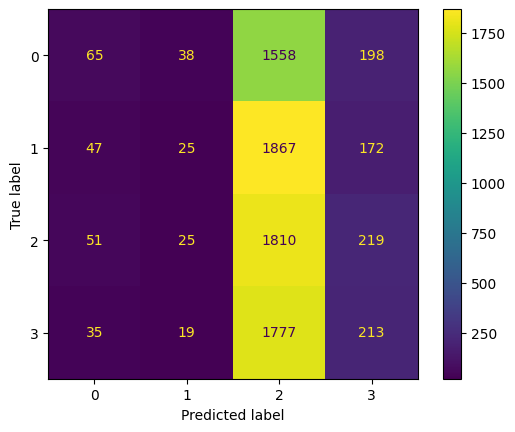

In [ ]:
count_preds_reg = model_count_reg.predict(X_test_count)
count_preds = model_count.predict(X_test_count)

f1_reg = f1_score(y_test, np.argmax(count_preds_reg, axis=1), average='macro')
f1 = f1_score(y_test, np.argmax(count_preds, axis=1), average='macro')

precision_reg = precision_score(y_test, np.argmax(count_preds_reg, axis=1), average='macro')
precision = precision_score(y_test, np.argmax(count_preds, axis=1), average='macro')

recall_reg = recall_score(y_test, np.argmax(count_preds_reg, axis=1), average='macro')
recall = recall_score(y_test, np.argmax(count_preds, axis=1), average='macro')

print('COUNT BASED MODEL')
print(f'Precision score with regularizer:{precision_reg}, without regularizer:{precision}')
print(f'Recall score with regularizer:{recall_reg}, without regularizer:{recall}')
print(f'F1 score with regularizer:{f1_reg}, without regularizer:{f1}')
conf_reg = confusion_matrix(y_test, np.argmax(count_preds_reg, axis=1))
conf = confusion_matrix(y_test, np.argmax(count_preds, axis=1))
print('CONFUSION MATRIX WITH REGULARIZED MODEL')
conf_reg = ConfusionMatrixDisplay(confusion_matrix=conf_reg)
conf_reg.plot()
plt.show()
print('CONFUSION MATRIX WITH NON-REGULARIZED MODEL')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()
#we realize a lot of figurative classes have been mispredicted, we try to predict on the dataset that has no irony or sarcasm hashtags to see if it boosts figurative class recognition
count_preds_reg = model_count_reg.predict(X_test_no_irony_sarcasm_count)
count_preds = model_count.predict(X_test_no_irony_sarcasm_count)

f1_reg = f1_score(y_test, np.argmax(count_preds_reg, axis=1), average='macro')
f1 = f1_score(y_test, np.argmax(count_preds, axis=1), average='macro')

precision_reg = precision_score(y_test, np.argmax(count_preds_reg, axis=1), average='macro')
precision = precision_score(y_test, np.argmax(count_preds, axis=1), average='macro')

recall_reg = recall_score(y_test, np.argmax(count_preds_reg, axis=1), average='macro')
recall = recall_score(y_test, np.argmax(count_preds, axis=1), average='macro')

print('COUNT BASED MODEL - NO IRONY & SARCASM')
print(f'Precision score with regularizer:{precision_reg}, without regularizer:{precision}')
print(f'Recall score with regularizer:{recall_reg}, without regularizer:{recall}')
print(f'F1 score with regularizer:{f1_reg}, without regularizer:{f1}')
print('CONFUSION MATRIX WITH REGULARIZED MODEL - NO IRONY & SARCASM')
conf_reg = confusion_matrix(y_test, np.argmax(count_preds_reg, axis=1))
conf = confusion_matrix(y_test, np.argmax(count_preds, axis=1))
conf_reg = ConfusionMatrixDisplay(confusion_matrix=conf_reg)
conf_reg.plot()
plt.show()
print('CONFUSION MATRIX WITH NON-REGULARIZED MODEL - NO IRONY & SARCASM')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()

254/254 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step
TFIDF BASED MODEL
Precision score with regularizer:0.6577748496853411, without regularizer:0.6182482974629323
Recall score with regularizer:0.7492797962522291, without regularizer:0.7419543270623782
F1 score with regularizer:0.6523698231729602, without regularizer:0.6484320322456364
CONFUSION MATRIX WITH REGULARIZED MODEL


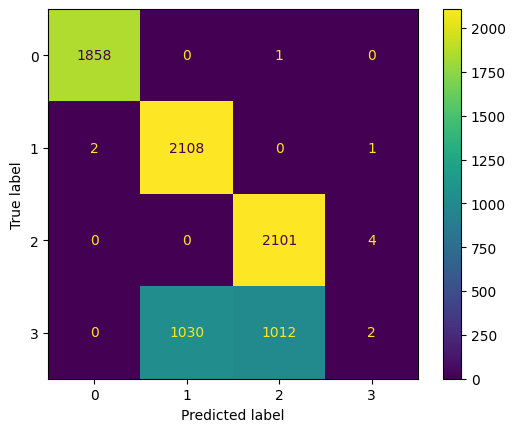

CONFUSION MATRIX WITH NON-REGULARIZED MODEL


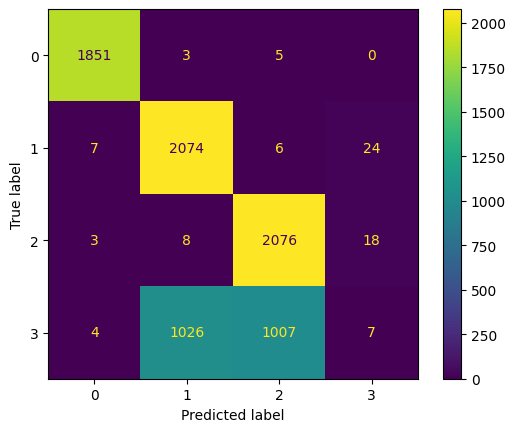

254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
TFIDF BASED MODEL - NO IRONY & SARCASM
Precision score with regularizer:0.5012464172441904, without regularizer:0.45592474061554483
Recall score with regularizer:0.38746554270841305, without regularizer:0.49725549123147306
F1 score with regularizer:0.31118169095292925, without regularizer:0.45249130700139123
CONFUSION MATRIX WITH REGULARIZED MODEL - NO IRONY & SARCASM


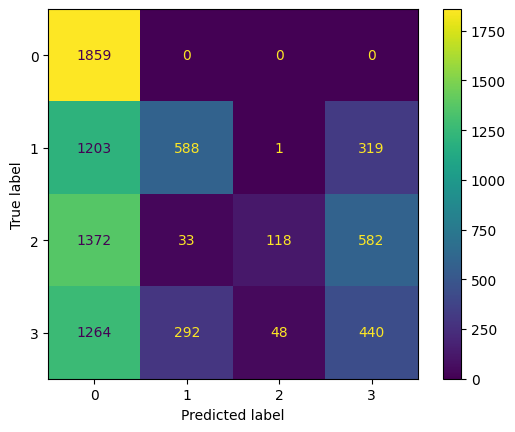

CONFUSION MATRIX WITH NON-REGULARIZED MODEL - NO IRONY & SARCASM


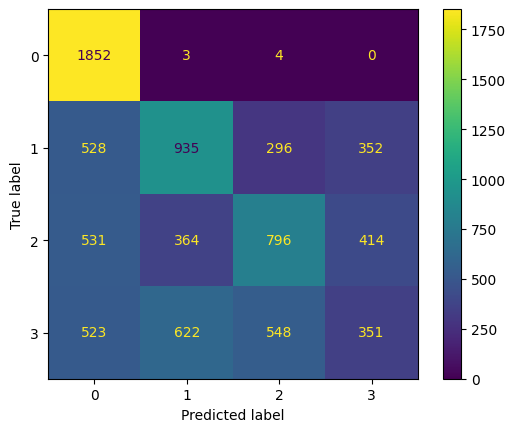

In [ ]:
tfidf_preds_reg = model_tfidf_reg.predict(X_test_tfidf)
tfidf_preds = model_tfidf.predict(X_test_tfidf)

f1_reg = f1_score(y_test, np.argmax(tfidf_preds_reg, axis=1), average='macro')
f1 = f1_score(y_test, np.argmax(tfidf_preds, axis=1), average='macro')

precision_reg = precision_score(y_test, np.argmax(tfidf_preds_reg, axis=1), average='macro')
precision = precision_score(y_test, np.argmax(tfidf_preds, axis=1), average='macro')

recall_reg = recall_score(y_test, np.argmax(tfidf_preds_reg, axis=1), average='macro')
recall = recall_score(y_test, np.argmax(tfidf_preds, axis=1), average='macro')

print('TFIDF BASED MODEL')
print(f'Precision score with regularizer:{precision_reg}, without regularizer:{precision}')
print(f'Recall score with regularizer:{recall_reg}, without regularizer:{recall}')
print(f'F1 score with regularizer:{f1_reg}, without regularizer:{f1}')
conf_reg = confusion_matrix(y_test, np.argmax(tfidf_preds_reg, axis=1))
conf = confusion_matrix(y_test, np.argmax(tfidf_preds, axis=1))
print('CONFUSION MATRIX WITH REGULARIZED MODEL')
conf_reg = ConfusionMatrixDisplay(confusion_matrix=conf_reg)
conf_reg.plot()
plt.show()
print('CONFUSION MATRIX WITH NON-REGULARIZED MODEL')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()
#same as before we predict on the dataset with no sarcasm or irony hashtags
tfidf_preds_reg = model_tfidf_reg.predict(X_test_no_irony_sarcasm_tfidf)
tfidf_preds = model_tfidf.predict(X_test_no_irony_sarcasm_tfidf)

f1_reg = f1_score(y_test, np.argmax(tfidf_preds_reg, axis=1), average='macro')
f1 = f1_score(y_test, np.argmax(tfidf_preds, axis=1), average='macro')

precision_reg = precision_score(y_test, np.argmax(tfidf_preds_reg, axis=1), average='macro')
precision = precision_score(y_test, np.argmax(tfidf_preds, axis=1), average='macro')

recall_reg = recall_score(y_test, np.argmax(tfidf_preds_reg, axis=1), average='macro')
recall = recall_score(y_test, np.argmax(tfidf_preds, axis=1), average='macro')

print('TFIDF BASED MODEL - NO IRONY & SARCASM')
print(f'Precision score with regularizer:{precision_reg}, without regularizer:{precision}')
print(f'Recall score with regularizer:{recall_reg}, without regularizer:{recall}')
print(f'F1 score with regularizer:{f1_reg}, without regularizer:{f1}')
conf_reg = confusion_matrix(y_test, np.argmax(tfidf_preds_reg, axis=1))
conf = confusion_matrix(y_test, np.argmax(tfidf_preds, axis=1))
print('CONFUSION MATRIX WITH REGULARIZED MODEL - NO IRONY & SARCASM')
conf_reg = ConfusionMatrixDisplay(confusion_matrix=conf_reg)
conf_reg.plot()
plt.show()
print('CONFUSION MATRIX WITH NON-REGULARIZED MODEL - NO IRONY & SARCASM')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
SVD200 BASED MODEL
Precision score with regularizer:0.6862393374112555, without regularizer:0.6247933270729494
Recall score with regularizer:0.7495173259434404, without regularizer:0.7477426044034877
F1 score with regularizer:0.6524280065428901, without regularizer:0.652198910662128
CONFUSION MATRIX WITH REGULARIZED MODEL


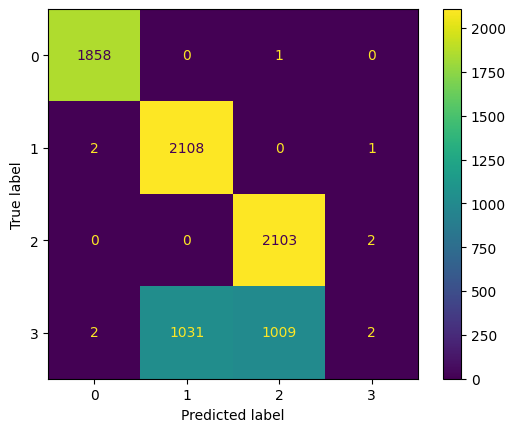

CONFUSION MATRIX WITH NON-REGULARIZED MODEL


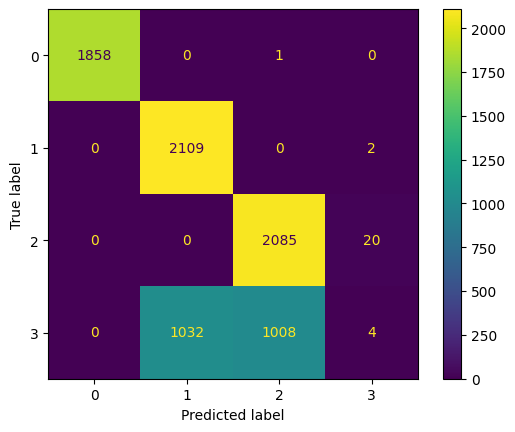

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
SVD200 BASED MODEL - NO IRONY & SARCASM
Precision score with regularizer:0.5219676636512682, without regularizer:0.46454775958612027
Recall score with regularizer:0.4470980318501628, without regularizer:0.39910180194240363
F1 score with regularizer:0.3875594804398403, without regularizer:0.314115296034323
CONFUSION MATRIX WITH REGULARIZED MODEL - NO IRONY & SARCASM


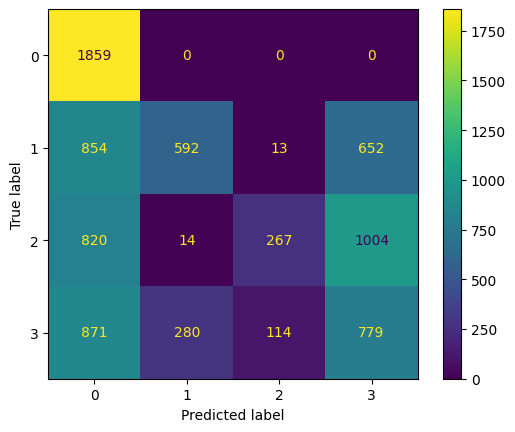

CONFUSION MATRIX WITH NON-REGULARIZED MODEL - NO IRONY & SARCASM


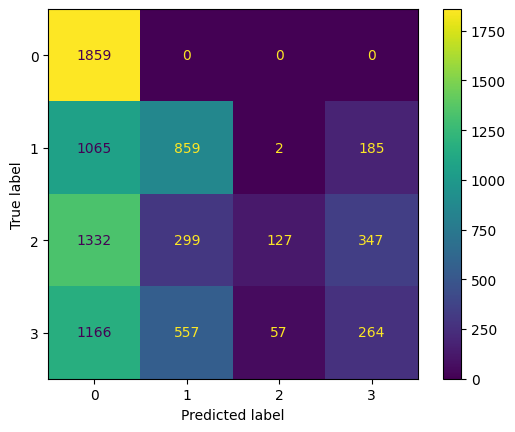

In [ ]:
svd200_preds_reg = model_svd200_reg.predict(X_test_svd200)
svd200_preds = model_svd200.predict(X_test_svd200)

f1_reg = f1_score(y_test, np.argmax(svd200_preds_reg, axis=1), average='macro')
f1 = f1_score(y_test, np.argmax(svd200_preds, axis=1), average='macro')

precision_reg = precision_score(y_test, np.argmax(svd200_preds_reg, axis=1), average='macro')
precision = precision_score(y_test, np.argmax(svd200_preds, axis=1), average='macro')

recall_reg = recall_score(y_test, np.argmax(svd200_preds_reg, axis=1), average='macro')
recall = recall_score(y_test, np.argmax(svd200_preds, axis=1), average='macro')

print('SVD200 BASED MODEL')
print(f'Precision score with regularizer:{precision_reg}, without regularizer:{precision}')
print(f'Recall score with regularizer:{recall_reg}, without regularizer:{recall}')
print(f'F1 score with regularizer:{f1_reg}, without regularizer:{f1}')
conf_reg = confusion_matrix(y_test, np.argmax(svd200_preds_reg, axis=1))
conf = confusion_matrix(y_test, np.argmax(svd200_preds, axis=1))
print('CONFUSION MATRIX WITH REGULARIZED MODEL')
conf_reg = ConfusionMatrixDisplay(confusion_matrix=conf_reg)
conf_reg.plot()
plt.show()
print('CONFUSION MATRIX WITH NON-REGULARIZED MODEL')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()
#same as before we predict on the dataset with no sarcasm or irony hashtags
svd200_preds_reg = model_svd200_reg.predict(X_test_no_svd200)
svd200_preds = model_svd200.predict(X_test_no_svd200)

f1_reg = f1_score(y_test, np.argmax(svd200_preds_reg, axis=1), average='macro')
f1 = f1_score(y_test, np.argmax(svd200_preds, axis=1), average='macro')

precision_reg = precision_score(y_test, np.argmax(svd200_preds_reg, axis=1), average='macro')
precision = precision_score(y_test, np.argmax(svd200_preds, axis=1), average='macro')

recall_reg = recall_score(y_test, np.argmax(svd200_preds_reg, axis=1), average='macro')
recall = recall_score(y_test, np.argmax(svd200_preds, axis=1), average='macro')

print('SVD200 BASED MODEL - NO IRONY & SARCASM')
print(f'Precision score with regularizer:{precision_reg}, without regularizer:{precision}')
print(f'Recall score with regularizer:{recall_reg}, without regularizer:{recall}')
print(f'F1 score with regularizer:{f1_reg}, without regularizer:{f1}')
conf_reg = confusion_matrix(y_test, np.argmax(svd200_preds_reg, axis=1))
conf = confusion_matrix(y_test, np.argmax(svd200_preds, axis=1))
print('CONFUSION MATRIX WITH REGULARIZED MODEL - NO IRONY & SARCASM')
conf_reg = ConfusionMatrixDisplay(confusion_matrix=conf_reg)
conf_reg.plot()
plt.show()
print('CONFUSION MATRIX WITH NON-REGULARIZED MODEL - NO IRONY & SARCASM')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
SVD100 BASED MODEL
Precision score with regularizer:0.6729583503026236, without regularizer:0.711639511066456
Recall score with regularizer:0.7469377488034139, without regularizer:0.7497502986027286
F1 score with regularizer:0.6513722519454463, without regularizer:0.6524702296513243
CONFUSION MATRIX WITH REGULARIZED MODEL


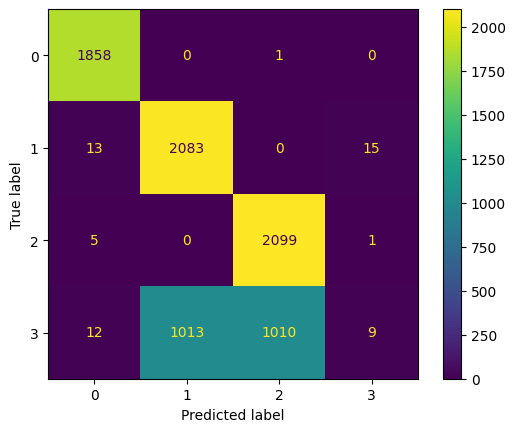

CONFUSION MATRIX WITH NON-REGULARIZED MODEL


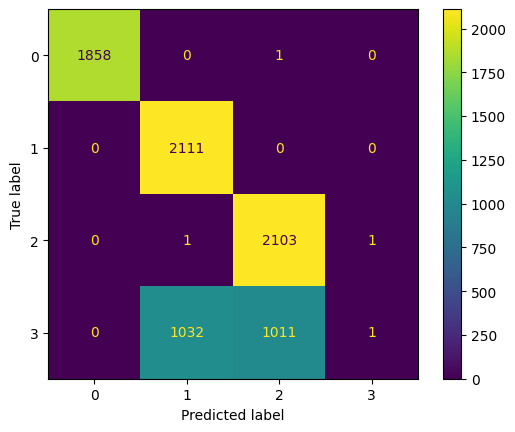

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
SVD100 BASED MODEL - NO IRONY & SARCASM
Precision score with regularizer:0.47696548810373623, without regularizer:0.45076421003622735
Recall score with regularizer:0.38500316443745014, without regularizer:0.4641320556931831
F1 score with regularizer:0.31455047090996974, without regularizer:0.37290743866432075
CONFUSION MATRIX WITH REGULARIZED MODEL - NO IRONY & SARCASM


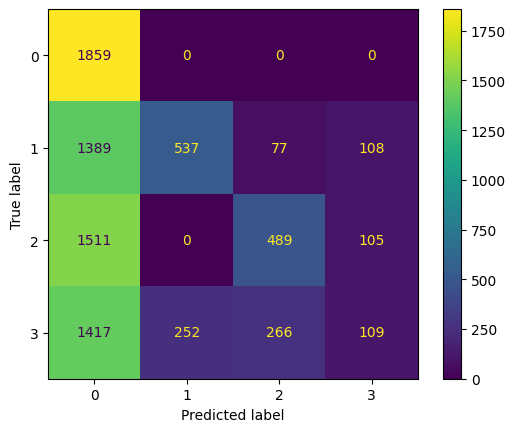

CONFUSION MATRIX WITH NON-REGULARIZED MODEL - NO IRONY & SARCASM


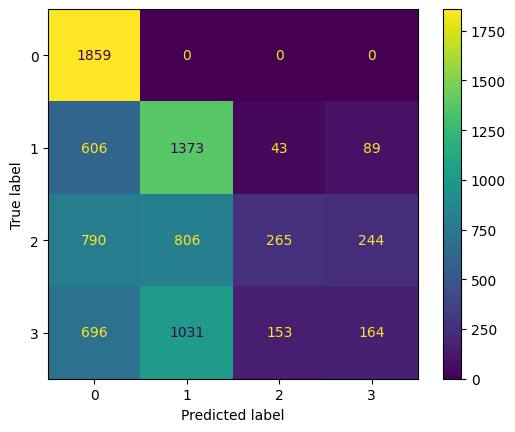

In [ ]:
svd100_preds_reg = model_svd100_reg.predict(X_test_svd100)
svd100_preds = model_svd100.predict(X_test_svd100)

f1_reg = f1_score(y_test, np.argmax(svd100_preds_reg, axis=1), average='macro')
f1 = f1_score(y_test, np.argmax(svd100_preds, axis=1), average='macro')

precision_reg = precision_score(y_test, np.argmax(svd100_preds_reg, axis=1), average='macro')
precision = precision_score(y_test, np.argmax(svd100_preds, axis=1), average='macro')

recall_reg = recall_score(y_test, np.argmax(svd100_preds_reg, axis=1), average='macro')
recall = recall_score(y_test, np.argmax(svd100_preds, axis=1), average='macro')

print('SVD100 BASED MODEL')
print(f'Precision score with regularizer:{precision_reg}, without regularizer:{precision}')
print(f'Recall score with regularizer:{recall_reg}, without regularizer:{recall}')
print(f'F1 score with regularizer:{f1_reg}, without regularizer:{f1}')
conf_reg = confusion_matrix(y_test, np.argmax(svd100_preds_reg, axis=1))
conf = confusion_matrix(y_test, np.argmax(svd100_preds, axis=1))
print('CONFUSION MATRIX WITH REGULARIZED MODEL')
conf_reg = ConfusionMatrixDisplay(confusion_matrix=conf_reg)
conf_reg.plot()
plt.show()
print('CONFUSION MATRIX WITH NON-REGULARIZED MODEL')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()
#same as before we predict on the dataset with no sarcasm or irony hashtags
svd100_preds_reg = model_svd100_reg.predict(X_test_no_svd100)
svd100_preds = model_svd100.predict(X_test_no_svd100)

f1_reg = f1_score(y_test, np.argmax(svd100_preds_reg, axis=1), average='macro')
f1 = f1_score(y_test, np.argmax(svd100_preds, axis=1), average='macro')

precision_reg = precision_score(y_test, np.argmax(svd100_preds_reg, axis=1), average='macro')
precision = precision_score(y_test, np.argmax(svd100_preds, axis=1), average='macro')

recall_reg = recall_score(y_test, np.argmax(svd100_preds_reg, axis=1), average='macro')
recall = recall_score(y_test, np.argmax(svd100_preds, axis=1), average='macro')

print('SVD100 BASED MODEL - NO IRONY & SARCASM')
print(f'Precision score with regularizer:{precision_reg}, without regularizer:{precision}')
print(f'Recall score with regularizer:{recall_reg}, without regularizer:{recall}')
print(f'F1 score with regularizer:{f1_reg}, without regularizer:{f1}')
conf_reg = confusion_matrix(y_test, np.argmax(svd100_preds_reg, axis=1))
conf = confusion_matrix(y_test, np.argmax(svd100_preds, axis=1))
print('CONFUSION MATRIX WITH REGULARIZED MODEL - NO IRONY & SARCASM')
conf_reg = ConfusionMatrixDisplay(confusion_matrix=conf_reg)
conf_reg.plot()
plt.show()
print('CONFUSION MATRIX WITH NON-REGULARIZED MODEL - NO IRONY & SARCASM')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
SVD50 BASED MODEL
Precision score with regularizer:0.7012539163910176, without regularizer:0.5864508045348699
Recall score with regularizer:0.7492956614602083, without regularizer:0.749628326965036
F1 score with regularizer:0.6530174253419079, without regularizer:0.6521202911165702
CONFUSION MATRIX WITH REGULARIZED MODEL


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


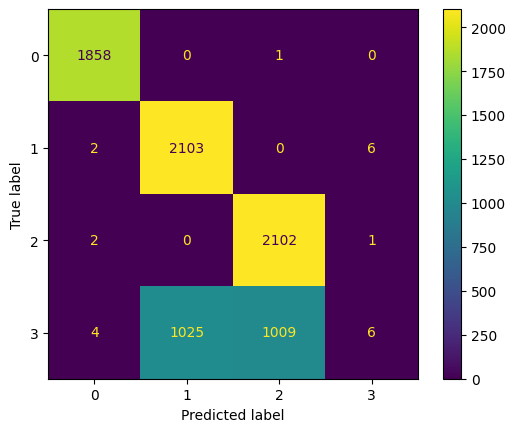

CONFUSION MATRIX WITH NON-REGULARIZED MODEL


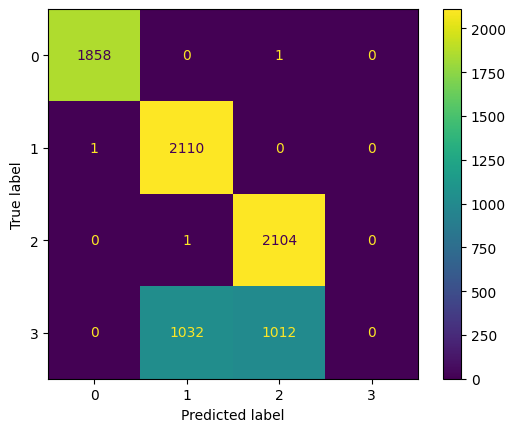

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
SVD50 BASED MODEL - NO IRONY & SARCASM
Precision score with regularizer:0.5034248034451623, without regularizer:0.4467552827445365
Recall score with regularizer:0.4156851010520088, without regularizer:0.47308290869387787
F1 score with regularizer:0.3518030289583666, without regularizer:0.3882246745369134
CONFUSION MATRIX WITH REGULARIZED MODEL - NO IRONY & SARCASM


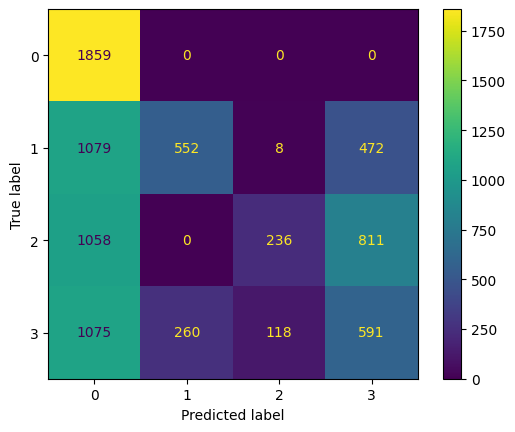

CONFUSION MATRIX WITH NON-REGULARIZED MODEL - NO IRONY & SARCASM


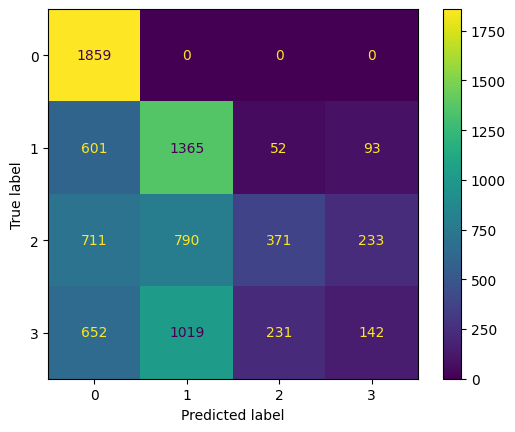

In [ ]:
svd50_preds_reg = model_svd50_reg.predict(X_test_svd50)
svd50_preds = model_svd50.predict(X_test_svd50)

f1_reg = f1_score(y_test, np.argmax(svd50_preds_reg, axis=1), average='macro')
f1 = f1_score(y_test, np.argmax(svd50_preds, axis=1), average='macro')

precision_reg = precision_score(y_test, np.argmax(svd50_preds_reg, axis=1), average='macro')
precision = precision_score(y_test, np.argmax(svd50_preds, axis=1), average='macro')

recall_reg = recall_score(y_test, np.argmax(svd50_preds_reg, axis=1), average='macro')
recall = recall_score(y_test, np.argmax(svd50_preds, axis=1), average='macro')

print('SVD50 BASED MODEL')
print(f'Precision score with regularizer:{precision_reg}, without regularizer:{precision}')
print(f'Recall score with regularizer:{recall_reg}, without regularizer:{recall}')
print(f'F1 score with regularizer:{f1_reg}, without regularizer:{f1}')
conf_reg = confusion_matrix(y_test, np.argmax(svd50_preds_reg, axis=1))
conf = confusion_matrix(y_test, np.argmax(svd50_preds, axis=1))
print('CONFUSION MATRIX WITH REGULARIZED MODEL')
conf_reg = ConfusionMatrixDisplay(confusion_matrix=conf_reg)
conf_reg.plot()
plt.show()
print('CONFUSION MATRIX WITH NON-REGULARIZED MODEL')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()
#same as before we predict on the dataset with no sarcasm or irony hashtags
svd50_preds_reg = model_svd50_reg.predict(X_test_no_svd50)
svd50_preds = model_svd50.predict(X_test_no_svd50)

f1_reg = f1_score(y_test, np.argmax(svd50_preds_reg, axis=1), average='macro')
f1 = f1_score(y_test, np.argmax(svd50_preds, axis=1), average='macro')

precision_reg = precision_score(y_test, np.argmax(svd50_preds_reg, axis=1), average='macro')
precision = precision_score(y_test, np.argmax(svd50_preds, axis=1), average='macro')

recall_reg = recall_score(y_test, np.argmax(svd50_preds_reg, axis=1), average='macro')
recall = recall_score(y_test, np.argmax(svd50_preds, axis=1), average='macro')

print('SVD50 BASED MODEL - NO IRONY & SARCASM')
print(f'Precision score with regularizer:{precision_reg}, without regularizer:{precision}')
print(f'Recall score with regularizer:{recall_reg}, without regularizer:{recall}')
print(f'F1 score with regularizer:{f1_reg}, without regularizer:{f1}')
conf_reg = confusion_matrix(y_test, np.argmax(svd50_preds_reg, axis=1))
conf = confusion_matrix(y_test, np.argmax(svd50_preds, axis=1))
print('CONFUSION MATRIX WITH REGULARIZED MODEL - NO IRONY & SARCASM')
conf_reg = ConfusionMatrixDisplay(confusion_matrix=conf_reg)
conf_reg.plot()
plt.show()
print('CONFUSION MATRIX WITH NON-REGULARIZED MODEL - NO IRONY & SARCASM')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()

## Tweets representation - Semantic embeddings

---



### Frequency based representation recap

Previously, we used BPE tokenization to build a subword vocabulary, and then generated tweet representations using CountVectorizer or TF-IDF (followed optionally by SVD). In that context, we were working with frequency-based features, not semantic embeddings.


### Word2Vec for subwords representation

Using Word2Vec, we want subwords dense vector representations that capture semantic relationships between the subwords.
For this to work, each subword needs its own learned vector based on context — this is what Word2Vec does.

### Word2Vec for tweets representation
After Word2Vec learns a vector for each subword, we still need a single vector for each tweet (since classifiers take fixed-size inputs), so

- We tokenize the tweet into subwords.
- We look up the embedding for each subword.
- We compute the average of all these vectors, which becomes the tweet's embedding.

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 29.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [ ]:
#before we train Word2Vec to get our embeddings we have to split our whole corpus (train['tweets']) according to our subword vocabulary to get subword embeddings

tweet_list = train['tweets'].tolist()
subword_tweets=[]
for tweet in tweet_list:
  subword_tweets.append(tokenizer.encode(tweet).tokens)

Before training Word2Vec, we tokenize each tweet into subwords using our BPE tokenizer.

This is necessary because Word2Vec expects input as a list of sentences, where each sentence is a list of tokens. Since we are working with subword-level embeddings (instead of whole words), we apply the tokenizer to every tweet to obtain subword sequences.

These tokenized tweets are then used to train Word2Vec, allowing us to obtain embeddings not for whole words, but for subword units. This is especially helpful in handling out-of-vocabulary words and capturing more fine-grained semantics.


In [ ]:
len(subword_tweets)

In [ ]:
#we use the gensim library to train our Word2Vec embeddings using ,as corpus all the tweets in the training database

from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()

tweet_w2vec = Word2Vec(subword_tweets, vector_size=300, window=5, workers=cpu)
tweet_w2vec.train(subword_tweets, total_examples=len(subword_tweets), epochs = 3)
tweet_wv = tweet_w2vec.wv

We have subwords embeddings, now we want to get to a tweet level representation.

In [ ]:
#we define a function that averages the embeddings of the sub-words inside a tweet to get a Word2Vec representation of the tweet

def tweet_vec(tweet):
  vector_size = tweet_wv.vector_size    # value/dimension
  wv_res = np.zeros(vector_size)
  ctr = 1
  for w in ' '.join(tokenizer.encode(tweet).tokens):  #make sure we tokenize our tweet according to our subword tokenizer since we have subword embedding vectors
    if w in tweet_wv:
      ctr += 1
      wv_res += tweet_wv.get_vector(w)
  wv_res =  wv_res/ctr

  return wv_res

In [ ]:
# Apply the averaging function to all tweets to get tweet embeddings
import numpy as np
train['w2v_embedding'] = train['tweets'].apply(tweet_vec)
test['w2v_embedding'] = test['tweets'].apply(tweet_vec)
test['w2v_embedding_no_irony_sarcasm'] = test['no_irony_sarcasm'].apply(tweet_vec)

# Convert the embeddings from list to numpy arrays
X_train_w2vec = train['w2v_embedding'].tolist()
X_test_w2vec = test['w2v_embedding'].tolist()
X_test_no_w2vec = test['w2v_embedding_no_irony_sarcasm'].tolist()
X_train_w2vec = np.array(X_train_w2vec)
X_test_w2vec = np.array(X_test_w2vec)
X_test_no_w2vec = np.array(X_test_no_w2vec)

Classificator model setup and training for Word2Vec

In [ ]:
INPUT_SHAPE = X_train_w2vec[0].shape
lr = 4*10**-3 # Learning rate

model_w2vec_reg = create_model(INPUT_SHAPE)
model_w2vec = create_model(INPUT_SHAPE, regularization=False)

model_w2vec_reg.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

model_w2vec.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

model_w2vec.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,476 (83.89 KB)

 Trainable params: 21,476 (83.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 30
batch_size = 500

model_w2vec_reg.fit(X_train_w2vec, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4039 - loss: 2.1505
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4865 - loss: 1.2395
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4891 - loss: 1.2177
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4895 - loss: 1.2186
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4924 - loss: 1.2032
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4904 - loss: 1.2040
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4953 - loss: 1.1938
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4958 - loss: 1.1919
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4929 - loss: 1.1974
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4918 - loss: 1.1993
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4975 - loss: 1.1857
Epoch 12/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

In [ ]:
epochs = 30
batch_size = 500

model_w2vec.fit(X_train_w2vec, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.4529 - loss: 1.1780
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5238 - loss: 1.0609
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5351 - loss: 1.0387
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5361 - loss: 1.0344
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5367 - loss: 1.0278
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5408 - loss: 1.0240
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5414 - loss: 1.0204
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5420 - loss: 1.0182
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5397 - loss: 1.0177
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5422 - loss: 1.0183
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5439 - loss: 1.0119
Epoch 12/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/st

### Evaluation of Word2Vec

Like we did earlier for TF-IDF and SVD, we want to evaluate both regularized and non-regularized versions of classifiers trained on:

- **Word2Vec**

For each configuration we:

- Compute precision, recall, and F1 (macro).
- Display confusion matrices to visualize performance.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
WORD2VEC BASED MODEL
Precision score with regularizer:0.471008824655736, without regularizer:0.42660247060762846
Recall score with regularizer:0.5245588607311717, without regularizer:0.5636357177207991
F1 score with regularizer:0.45573260069561694, without regularizer:0.4839472215779361
CONFUSION MATRIX WITH REGULARIZED MODEL


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


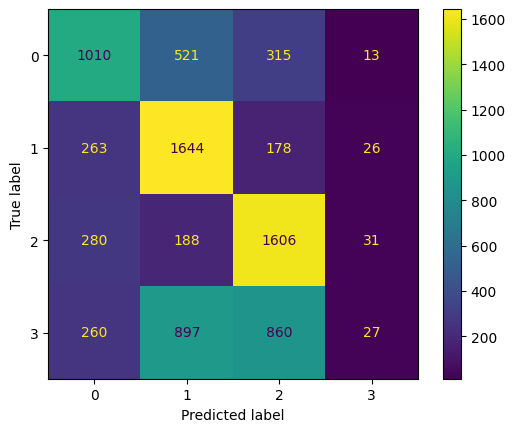

CONFUSION MATRIX WITH NON-REGULARIZED MODEL


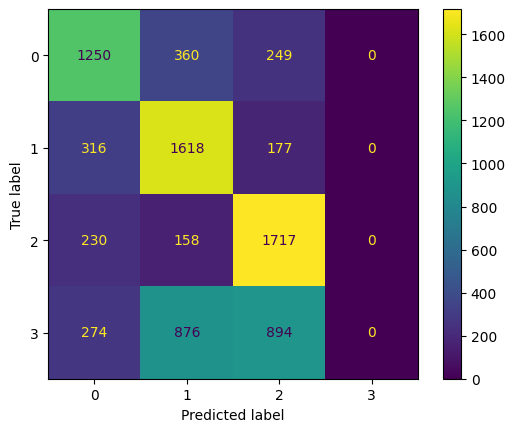

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
WORD2VEC BASED MODEL - NO IRONY & SARCASM
Precision score with regularizer:0.293966451621406, without regularizer:0.22257890352004012
Recall score with regularizer:0.3071862251369308, without regularizer:0.30488807642101323
F1 score with regularizer:0.25667791425328723, without regularizer:0.24026117463394894
CONFUSION MATRIX WITH REGULARIZED MODEL - NO IRONY & SARCASM


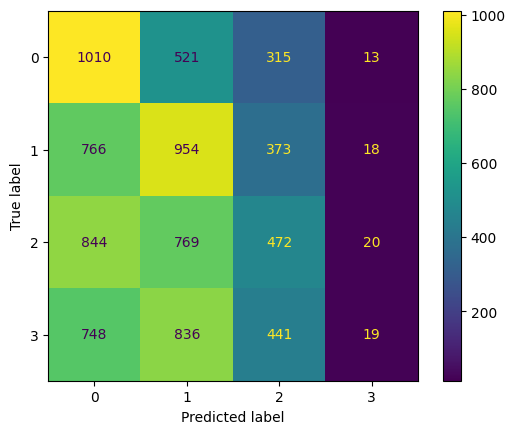

CONFUSION MATRIX WITH NON-REGULARIZED MODEL - NO IRONY & SARCASM


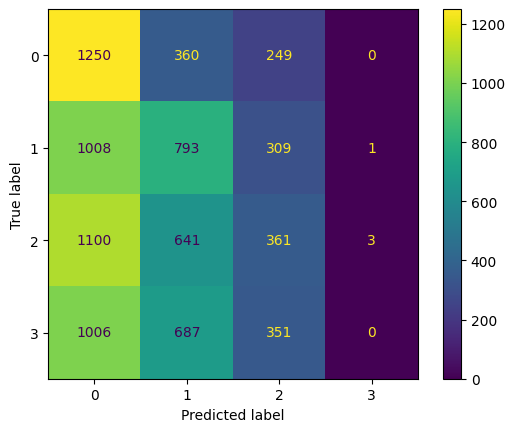

In [ ]:
w2vec_preds_reg = model_w2vec_reg.predict(X_test_w2vec)
w2vec_preds = model_w2vec.predict(X_test_w2vec)

f1_reg = f1_score(y_test, np.argmax(w2vec_preds_reg, axis=1), average='macro')
f1 = f1_score(y_test, np.argmax(w2vec_preds, axis=1), average='macro')

precision_reg = precision_score(y_test, np.argmax(w2vec_preds_reg, axis=1), average='macro')
precision = precision_score(y_test, np.argmax(w2vec_preds, axis=1), average='macro')

recall_reg = recall_score(y_test, np.argmax(w2vec_preds_reg, axis=1), average='macro')
recall = recall_score(y_test, np.argmax(w2vec_preds, axis=1), average='macro')

print('WORD2VEC BASED MODEL')
print(f'Precision score with regularizer:{precision_reg}, without regularizer:{precision}')
print(f'Recall score with regularizer:{recall_reg}, without regularizer:{recall}')
print(f'F1 score with regularizer:{f1_reg}, without regularizer:{f1}')
conf_reg = confusion_matrix(y_test, np.argmax(w2vec_preds_reg, axis=1))
conf = confusion_matrix(y_test, np.argmax(w2vec_preds, axis=1))
print('CONFUSION MATRIX WITH REGULARIZED MODEL')
conf_reg = ConfusionMatrixDisplay(confusion_matrix=conf_reg)
conf_reg.plot()
plt.show()
print('CONFUSION MATRIX WITH NON-REGULARIZED MODEL')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()
#now we try and predict from the embedded test dataset without irony and sarcasm
w2vec_preds_reg = model_w2vec_reg.predict(X_test_no_w2vec)
w2vec_preds = model_w2vec.predict(X_test_no_w2vec)

f1_reg = f1_score(y_test, np.argmax(w2vec_preds_reg, axis=1), average='macro')
f1 = f1_score(y_test, np.argmax(w2vec_preds, axis=1), average='macro')

precision_reg = precision_score(y_test, np.argmax(w2vec_preds_reg, axis=1), average='macro')
precision = precision_score(y_test, np.argmax(w2vec_preds, axis=1), average='macro')

recall_reg = recall_score(y_test, np.argmax(w2vec_preds_reg, axis=1), average='macro')
recall = recall_score(y_test, np.argmax(w2vec_preds, axis=1), average='macro')

print('WORD2VEC BASED MODEL - NO IRONY & SARCASM')
print(f'Precision score with regularizer:{precision_reg}, without regularizer:{precision}')
print(f'Recall score with regularizer:{recall_reg}, without regularizer:{recall}')
print(f'F1 score with regularizer:{f1_reg}, without regularizer:{f1}')
conf_reg = confusion_matrix(y_test, np.argmax(w2vec_preds_reg, axis=1))
conf = confusion_matrix(y_test, np.argmax(w2vec_preds, axis=1))
print('CONFUSION MATRIX WITH REGULARIZED MODEL - NO IRONY & SARCASM')
conf_reg = ConfusionMatrixDisplay(confusion_matrix=conf_reg)
conf_reg.plot()
plt.show()
print('CONFUSION MATRIX WITH NON-REGULARIZED MODEL - NO IRONY & SARCASM')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()

### Considerations
- Before running the last part of the project be aware that there is some conflict between the Transformers library used for the LLM and gensin library used in Word2Vec, likely because they use different veriosns of numpy.

 We can't run both parts together, so make sure to run the following part of the project only after the previous one has been done successfully.

- LLM predictions are trained only on 10% of the dataset because they are highly computationally expensive, expecially using COT prompting
- In zero-shot we also evaluated the ability of the model to correctly follow the prompt, which was to only answer with the classification, therefore all answers in which the first word is not one of the available classes are counted as random answers by our design.

## Using pre-trained LLMs for classification

### Pre-trained LLM (Phi-3) for Prompt-Based Classification

In this section, we use a pre-trained large language model — `microsoft/Phi-3-mini-128k-instruct` — to classify tweets without training a model ourselves.

Instead of converting tweets into numeric vectors and fitting a neural network, we simply ask the LLM to read a tweet and generate a class label using a carefully written prompt.

Large Language Models have been pre-trained on vast corpora and can understand nuanced language patterns. Prompt-based inference allows us to utilize this capability for zero-shot or few-shot classification.

We will use two methods for prompt based classification:
- Zero shot prompting
- Chain of thoughts prompting


In [ ]:
! pip install bitsandbytes --prefer-binary
! pip install huggingface_hub
! pip install transformers==4.48.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
#I was getting errors that I didn't know how to solve using the code from Lab 6 so I used Copilot to help me fix them
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
import torch

torch.random.manual_seed(0)
modelname = "microsoft/Phi-3-mini-128k-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    modelname,
    device_map="cuda",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    quantization_config=bnb_config
)

tokenizer = AutoTokenizer.from_pretrained(modelname)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/3.48k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

In [ ]:
#define generation arguments for our LLM
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "return_full_text": False,
    "temperature": 0.6,
    "do_sample": True,
    "top_p":0.9,
}

Device set to use cuda


In [ ]:
# We shuffle the train dataset to ensure that we have different classes and not just 'figurative'
from sklearn.model_selection import train_test_split

test_no_col = test.drop(columns=['class'])
y = test['class']

# Shuffle stratifying according to the labels
temp_test, _, temp_y, _ = train_test_split(test_no_col, y, test_size=0.9, stratify=y)

# Combine back in  a single dataframe
test_shuffle = pd.concat([temp_test, temp_y], axis=1).reset_index(drop=True)


In [ ]:
test_shuffle

,tweets,class
0,"I'm glad that Corey with an ""E"" is actually ge...",sarcasm
1,No direct correlations there for sure. #Sarcas...,sarcasm
2,Man sues after arrest 4 writing profanity on t...,irony
3,"@rickawerner3 I blame god, he created the univ...",sarcasm
4,How do we prepare our high school students for...,regular
...,...,...
806,Did your know? We have 3 #Dermalogica #Experts...,regular
807,@fyeahmfabello @femfreq I'm sure you're asked ...,sarcasm
808,Its amazing that a track like this is not on e...,irony
809,So much so that I'm sharing it again in attent...,irony


In [ ]:
import numpy as np

test_shuffle.loc[test_shuffle['class']=='regular', 'class'] = 0
test_shuffle.loc[test_shuffle['class']=='irony', 'class'] = 1
test_shuffle.loc[test_shuffle['class']=='sarcasm', 'class'] = 2
test_shuffle.loc[test_shuffle['class']=='figurative', 'class'] =3

y_test_shuffle = np.array(test_shuffle['class'])
y_test_shuffle = y_test_shuffle.astype('int32')

In [ ]:
# test if the shuffling worked
fig = 0
ir = 0
sar = 0
reg = 0

for i in y_test_shuffle:
  if i == 0:
    reg+=1
  if i ==1:
    ir+=1
  if i==2:
    sar+=1
  if i==3:
    fig+=1

print(f'Regular:{reg}\nIrony:{ir}\nSarcasm:{sar}\nFigurative:{fig}')

Regular:186
Irony:211
Sarcasm:210
Figurative:204


## LLM classificator using a Pre-trained LLM (Phi-3)

In this section, we leverage the Microsoft Phi-3 model to classify tweets into one of four categories: sarcasti, ironic, figurative, or none.

Unlike earlier approaches that required training on labeled data, we rely on the **zero-shot** capabilities of the LLM to infer labels directly from text via **prompts**.



### - Method 1: Zero-Shot Prompting
A direct instruction-only prompt is used, in our case the prompt is:


> 'Given the following published tweet on the app Twitter tell me if its content is sarcastic, ironic, figurative (both sarcastic and ironic) or none of the following. Answer only with either sarcastic, ironic, figurative or none.'

The model is expected to return one of the target class labels without additional reasoning.

In [ ]:
test_shuffle.shape[0]

811

In [ ]:
import random
# Start by using zero shot prompting
prompt='Given the following published tweet on the app Twitter tell me if its content is sarcastic, ironic, figurative (both sarcastic and ironic) or none of the following. Answer only with either sarcastic, ironic, figurative or none.'

total=0
print_every = 50

pred_llm_zero_shot=[]

# We only predict the first 811 labels because the model takes a long time to run
for i in range(test_shuffle.shape[0]):
  sentence = test_shuffle['tweets'][i]
  full_prompt_content = prompt+sentence
  messages = [
    {"role": "user", "content": full_prompt_content},
    ]
  output = pipe(messages, **generation_args)
  answer = output[0]['generated_text'].lower().replace("\n", " ").strip()
  output_label = -1
  if answer.startswith('none'):
    output_label = 0
  if answer.startswith('ironic'):
    output_label = 1
  if answer.startswith('sarcastic'):
    output_label = 2
  if answer.startswith('figurative'):
    output_label = 3

  if output_label == -1:
    print(answer)
    output_label = random.randint(0, 3) #to ensure the length of the predicted labels is equal to y_test if there is no prediction we produce a random label

  total+=1
  if total%print_every==0:
    print(total)
  pred_llm_zero_shot.append(output_label)

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


the content of the tweet is sarcastic. the user is mocking the idea of creation


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


50
the content of the tweet is ironic. the hashtag #sarcastic implies
the content of this tweet is ironic.
the content of this tweet is sarcastic.
100
the content of the tweet is sarcastic. the user is expressing displeasure at
this tweet contains both irony and sarcasm. the irony lies in the statement that
the content of the tweet is ironic.
the content of this tweet can be classified as both sarcastic and ironic. the
150
the content of the tweet appears to be sarcastic. the phrase "never!" in
200
the content of this tweet is ironic.
the content of the tweet is ironic. the user is highlighting the fact that while the
250
the content of this tweet is sarcastic.
based on the provided text, it can be inferred that the content of the tweet is sar
300
this tweet is sarcastic. the author is using sarcasm to mock the idea that
350
the content of the tweet can be classified as ironic. the tweet is highlighting
the content of the tweet is sarcastic. the use of the hashtag #s
400
450
the conten

## Model Evaluation - Zero shot prompting

### - LLM-based Prompting

We evaluate two inference-only LLM approaches using the Phi-3 model:
- **Zero-Shot Prompting**: A direct prompt asking for sarcasm/irony/etc.
- **Chain-of-Thought Prompting**: Adds reasoning and explanation before classification.

We compare LLM predictions to the human-labeled dataset using the same metrics above.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

LLM ZERO-SHOT PROMPTING BASED MODEL
Precision score:0.5641380231358679
Recall score:0.48015531315721516
F1 score:0.49457988382004625
CONFUSION MATRIX


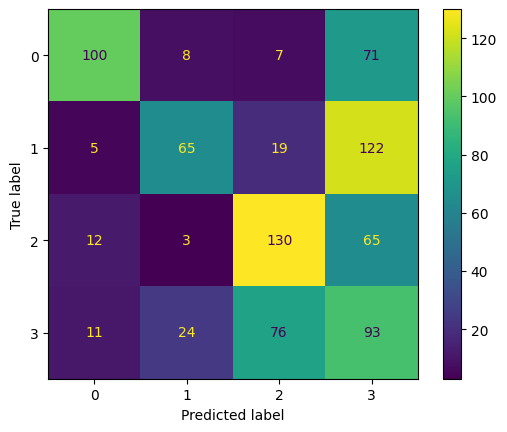

In [ ]:
f1 = f1_score(y_test_shuffle, np.array(pred_llm_zero_shot), average='macro')

precision = precision_score(y_test_shuffle, np.array(pred_llm_zero_shot), average='macro')

recall = recall_score(y_test_shuffle, np.array(pred_llm_zero_shot), average='macro')

print('LLM ZERO-SHOT PROMPTING BASED MODEL')
print(f'Precision score:{precision}')
print(f'Recall score:{recall}')
print(f'F1 score:{f1}')
conf = confusion_matrix(y_test_shuffle, np.array(pred_llm_zero_shot))
print('CONFUSION MATRIX')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()

#### - Method 2: Chain-of-Thought Prompting
To encourage more thoughtful responses, we ask the model to explain its reasoning before producing a label, we used the following prompt:


> 'Given the following published tweet on the app Twitter tell me if its content is sarcastic, ironic, figurative (both sarcastic and ironic) or none of the following. Answer using the words sarcastic, ironic, figurative or none and explain your reasoning behind the answer.'

We then extract the label from the explanation using keyword matching.



In [ ]:
#now use chain of thought prompting
prompt='Given the following published tweet on the app Twitter tell me if its content is sarcastic, ironic, figurative (both sarcastic and ironic) or none of the following. Answer using the words sarcastic, ironic, figurative or none and explain your reasoning behind the answer.'

total=0
print_every = 50

pred_llm_chain_of_thought=[]

for i in range(test_shuffle.shape[0]):
  sentence = train['tweets'][i]
  label = train['class'][i]
  full_prompt_content = prompt+sentence
  messages = [
    {"role": "user", "content": full_prompt_content},
    ]
  output = pipe(messages, **generation_args)
  answer = output[0]['generated_text'].lower().replace("\n", " ").strip()
  output_label = -1
  if 'ironic' in answer or 'irony' in answer:
    output_label = 1
  if 'sarcastic' in answer or 'sarcasm' in answer:
    output_label = 2
  if 'figurative' in answer or 'both sarcastic and ironic' in answer or 'both ironic and sarcastic' in answer:
    output_label = 3
  if 'none' in answer or 'neither' in answer:
    output_label = 0

  if output_label == -1:
    print(answer)
    output_label = random.randint(0, 3) #to ensure the length of the predicted labels is equal to y_test if there is no prediction we produce a random label

  total+=1
  if total%print_every==0:
    print(total)
  pred_llm_chain_of_thought.append(output_label)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800


## Model Evaluation - Chain Of Thoughts Prompting

We do what we did earlier for zero shot but using COT prompting

- **Chain-of-Thought Prompting**: Adds reasoning and explanation before classification.




LLM CHAIN-OF-THOUGHT PROMPTING BASED MODEL
Precision score:0.2061294317064603
Recall score:0.26518628778525627
F1 score:0.23148955361952403
CONFUSION MATRIX


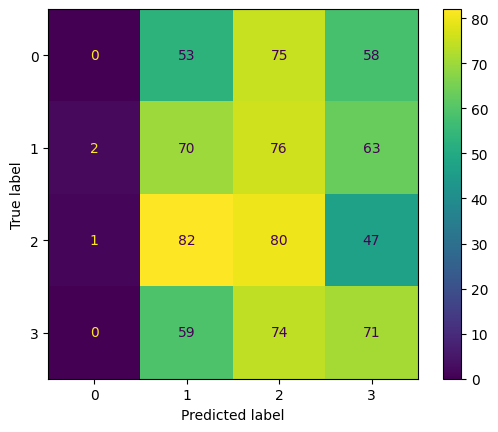

In [ ]:
f1 = f1_score(y_test_shuffle, np.array(pred_llm_chain_of_thought), average='macro')

precision = precision_score(y_test_shuffle, np.array(pred_llm_chain_of_thought), average='macro')

recall = recall_score(y_test_shuffle, np.array(pred_llm_chain_of_thought), average='macro')

print('LLM CHAIN-OF-THOUGHT PROMPTING BASED MODEL')
print(f'Precision score:{precision}')
print(f'Recall score:{recall}')
print(f'F1 score:{f1}')
conf = confusion_matrix(y_test_shuffle, np.array(pred_llm_chain_of_thought))
print('CONFUSION MATRIX')
conf = ConfusionMatrixDisplay(confusion_matrix=conf)
conf.plot()
plt.show()